## This notebook generates the components of Figure 2 

in "Entrained debris records regrowth of the Greenland Ice Sheet after the last interglacial" 

---
That figure contains the following components

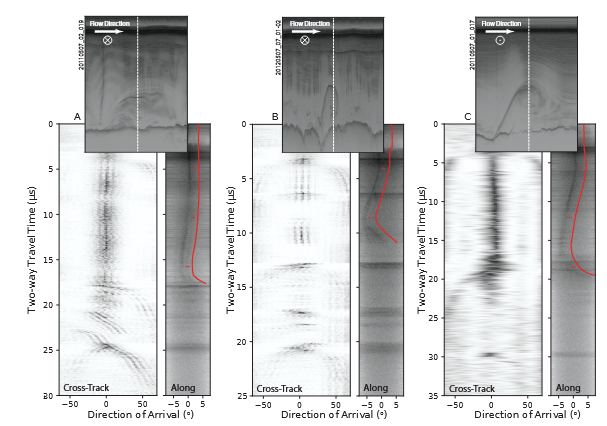


In [5]:
#############################################
### Necessary input statements

######## System untilities
import os
import shutil
import sys
import glob

######## Numerical and plotting tools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

######## Optimization tools
from scipy.ndimage import uniform_filter1d
def robust_local_column_variance(arr2d, window=11):
    from scipy.ndimage import uniform_filter1d
    local_mean = uniform_filter1d(arr2d, size=window, axis=0, mode='reflect')
    diffsq = (arr2d - local_mean) ** 2
    return uniform_filter1d(diffsq, size=window, axis=0, mode='reflect')

######## Any necessary path additions can go here:
sys.path.append('/mnt/data01/Code/opr_python/')

######## OPR library tools
import opr_python as ndh

generate_pdfs_flag = 0

In [4]:
import os
import shutil
import sys
sys.path.append('/mnt/g/My Drive/Python_Code/')
sys.path.append('/mnt/data01/Code/')

import glob
import tqdm
import contextlib
import io

import NDH_Tools as ndh
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

import xarray as xr
import rioxarray as rxr

from scipy.ndimage import uniform_filter1d
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from scipy.stats import f

def robust_local_column_variance(arr2d, window=11):
    from scipy.ndimage import uniform_filter1d
    local_mean = uniform_filter1d(arr2d, size=window, axis=0, mode='reflect')
    diffsq = (arr2d - local_mean) ** 2
    return uniform_filter1d(diffsq, size=window, axis=0, mode='reflect')



Center Frequency: 195000000.0


100%|██████████████████████████████████████| 2696/2696 [00:03<00:00, 767.99it/s]


Fixed parameter structure
Center Frequency: 195000000.0


100%|██████████████████████████████████████| 2995/2995 [00:22<00:00, 135.31it/s]


Center Frequency: 195000000.0


100%|██████████████████████████████████████| 2857/2857 [00:03<00:00, 772.32it/s]


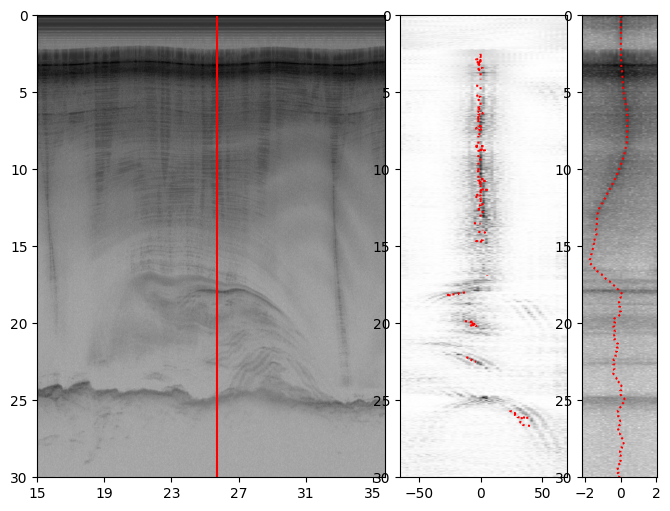

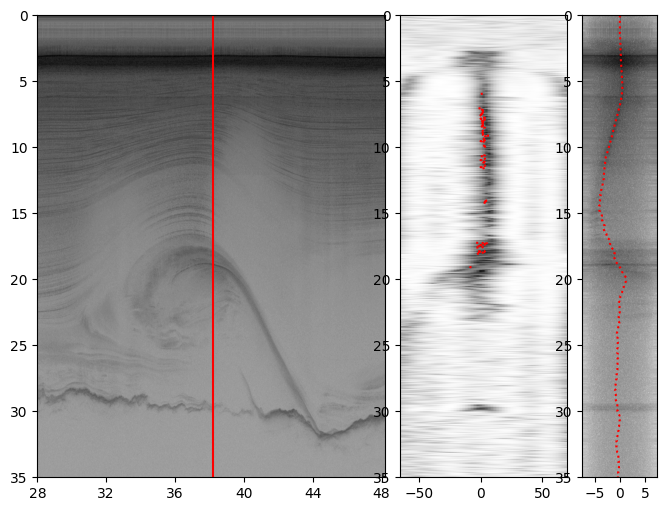

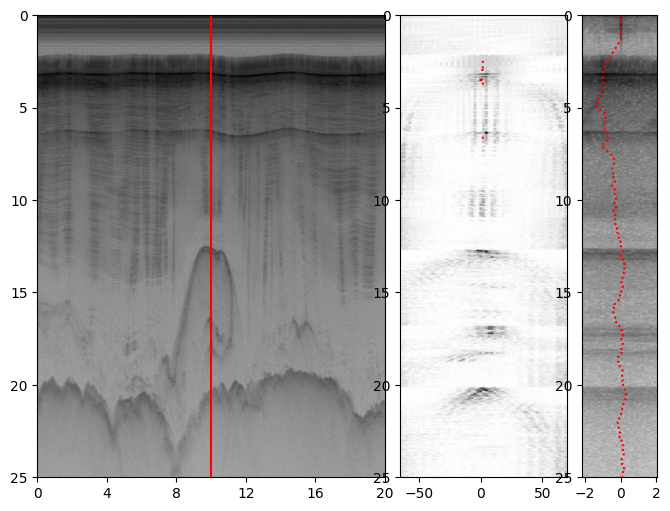

In [16]:
###########################################################
### Generate all 3 panels

data_root = '/mnt/data02/Dataverse_TestData/EntrainedDebris/'
file_roots = [['Data_20110507_02_019'],['Data_20120507_07_001','Data_20120507_07_002'],['Data_20110507_01_017']]
trace_inds = [600,770,245]
trace_inds = [1485,1550,600]
figure_panel = ['a','b','c']
ymax=[30,35,25]

for ind0,fn_list in enumerate(file_roots):

    ########################################################## Pull out and load the radar data
    trace_ind = trace_inds[ind0]
    music_names = []
    standard_names = []
    qlook_names = []   
    
    for file_target in fn_list:
        music_names.append(data_root+'Music_'+file_target+'.mat')
        standard_names.append(data_root+'SLC_'+file_target+'.mat')
        
    music_data = ndh.radar_load_music(music_names)
    standardradar_data, standarddepth_data = ndh.radar_load(standard_names,0,2)

    ###########################################################
    ### Generate the Doppler Files
    sdoppler_data = ndh.delay_doppler(standardradar_data, window_size=300, target_ind=0, ind_spacing=25, deg0_or_rad1=0, return_fft=1)
    
    ############# Identifying the indecies for each dataset for the animation
    music_inds = ndh.find_nearest_xy(np.stack([music_data['x'],music_data['y']]).T,
                                     np.stack([sdoppler_data['x'][trace_ind:trace_ind+1],sdoppler_data['y'][trace_ind:trace_ind+1]]).T)
    music_inds = np.unique(music_inds['index'])
    
    standard_inds = ndh.find_nearest_xy(np.stack([standardradar_data['x'],standardradar_data['y']]).T,
                                       np.stack([sdoppler_data['x'][trace_ind:trace_ind+1],sdoppler_data['y'][trace_ind:trace_ind+1]]).T)
    standard_inds = np.unique(standard_inds['index'])

    ############# Identifying the maximum in the along-track slopes
    theta_deg2 = sdoppler_data['slope_axis']
    slope_ind = np.argmax(sdoppler_data['doppler_data'],axis=2)
    slope_variance = robust_local_column_variance(slope_ind)
    variance_mask = np.where(np.cumsum(slope_variance > 300,axis=1) > 5)
    
    slope_value = sdoppler_data['slope_axis'][slope_ind]
    slope_ind = slope_ind.astype(float)
    slope_ind[variance_mask] = np.nan
    slope_value[variance_mask] = np.nan
    slope_value = uniform_filter1d(slope_value, size=50, axis=1, mode='reflect')
    slope_ind = uniform_filter1d(slope_ind, size=50, axis=1, mode='reflect')

    ############# Identifying the maximum in the across-track slopes
    theta_deg1 = np.rad2deg(music_data['Tomo']['theta'][:,0])[:,0]
    slope_ind2 = np.argmax(10*np.log10(music_data['Tomo']['img'][:,:,music_inds]),axis=1)
    slope_variance2 = robust_local_column_variance(slope_ind2)
    variance_mask2 = np.where(slope_variance2 > 2)
    
    slope_value2 = theta_deg1[slope_ind2]
    slope_ind2 = slope_ind2.astype(float)
    slope_ind2[variance_mask2] = np.nan
    slope_value2[variance_mask2] = np.nan
    slope_ind2[variance_mask2] = np.nan
    slope_value2[variance_mask2] = np.nan
    
    ############# Generate_the_figure
    fig = plt.figure(figsize=(8,6))
    
    gs = fig.add_gridspec(1,7,wspace=0.2,hspace=1)
    ax1 = fig.add_subplot(gs[0:4])
    ax2 = fig.add_subplot(gs[4:6])
    ax3 = fig.add_subplot(gs[6])

    ############## Main Radar Panel
    ax1.imshow(10*np.log10(np.abs(standardradar_data['Data'])**2),extent=[standardradar_data['distance'][0]/1000, standardradar_data['distance'][-1]/1000, 
                                     standardradar_data['Time'][0]*10**6, standardradar_data['Time'][-1]*10**6],origin='lower',cmap='gray_r')
    ax1.axvline(standardradar_data['distance'][standard_inds]/1000,c='red')
    ax1.set_aspect('auto')
    ax1.set_ylim([ymax[ind0],0])
    ax1.set_xlim([standardradar_data['distance'][standard_inds]/1000-10,standardradar_data['distance'][standard_inds]/1000+10])  
    ax1.set_xticks(range(int(ax1.get_xlim()[0]), int(ax1.get_xlim()[1]) + 1,4))

    music_edge_trim = 2
    imdata = ax2.imshow(10*np.log10(music_data['Tomo']['img'][:,music_edge_trim+1:-music_edge_trim,music_inds]),
                        extent=[theta_deg1[music_edge_trim+1],theta_deg1[-music_edge_trim],
                                music_data['Time'][0]*1e6,music_data['Time'][-1]*1e6],
                        origin='lower',aspect='auto',cmap='gray_r')  
    ax2.set_ylim([ymax[ind0],0])
    ax2.plot(slope_value2, music_data['Time']*1e6,':',c='red')
    
    ############## Along Track Slope
    imdata = ax3.imshow(sdoppler_data['doppler_data'][trace_ind,:,:],extent=[theta_deg2[0],theta_deg2[-1],
                                                                             sdoppler_data['Time'][0]*1e6,sdoppler_data['Time'][-1]*1e6],
                                    origin='lower',aspect='auto',cmap='gray_r')
    ax3.plot(slope_value[trace_ind,:],sdoppler_data['Time']*1e6,':',c='red')
    ax3.set_ylim([ymax[ind0],0])


    if generate_pdfs_flag == 1:
        plt.savefig('Matplotlib_Fig2_'+figure_panel[ind0]+'.pdf')